I fixed the TPCF issues, but now the delta sigma projection integration is being troublesome. I'm gonna do them for a few rp_bins to figure out what is sensible agian. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [2]:
import numpy as np
from glob import glob
from os import path

In [3]:
from pearce.mocks.kittens import TestBox, TrainingBox
from halotools.mock_observables import tpcf# as halotools_tpcf
from halotools.mock_observables import counts_in_cylinders
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml

In [4]:
output_dir = './'# '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [5]:
config_fname = 'xi_cosmo_trainer.yaml'

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [6]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [7]:
#, particles = False, downsample_factor = 1e-2)

In [8]:
from halotools.mock_observables import return_xyz_formatted_array

In [9]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
np.random.seed(0)
N = 5
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

n_cores = 1
bins = np.r_[np.arange(1,10), np.round(np.logspace(1,2,7))]

In [10]:
bins

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  15.,
        22.,  32.,  46.,  68., 100.])

In [11]:
def calc_cics(cat, hod_dicts):
    cics = np.zeros((len(hod_dicts), bins.shape[0]-1))
    for i, hd in enumerate(hod_dicts):
        cat.populate(hd)

        x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
        pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox).astype(float)

        cic = counts_in_cylinders(pos_g, pos_g, proj_search_radius = 2,
                       cylinder_half_length = 10, 
                       period=cat.Lbox, num_threads=n_cores)
        #print np.max(cic)
        hist, _ = np.histogram(cic, bins = bins, density=True)
        cics[i] = hist
        
    return cics

In [12]:
train_cics = np.load('/u/ki/swmclau2/Git/pearce/bin/cic/train_cics.npy')
test_cics = np.load('/u/ki/swmclau2/Git/pearce/bin/cic/test_cics.npy')

In [26]:
hod_idx = 0

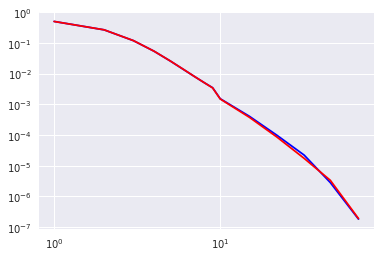

In [27]:
plt.plot(bins[:-1], train_cics[:,hod_idx,:].mean(axis = 0), color = 'b', label = 'Train')
plt.plot(bins[:-1], test_cics[:,hod_idx,:].mean(axis = 0), color = 'r', label = 'Test')

plt.loglog();

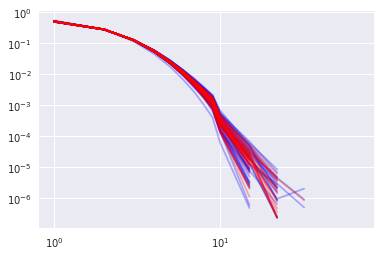

In [25]:
plt.plot(bins[:-1], train_cics[:,hod_idx,:].T, alpha = 0.3, color = 'b', label = 'Train')
plt.plot(bins[:-1], test_cics[:,hod_idx,:].T, alpha = 0.3, color = 'r', label = 'Test')

plt.loglog();